# ARIMA (USING SARIMA)

[Dataset loading](http://alkaline-ml.com/pmdarima/auto_examples/datasets/example_load_data.html)

[Why Are Time Series Special? : Time Series Talk](https://www.youtube.com/watch?v=ZoJ2OctrFLA&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3)

[ARIMA Model Python Example — Time Series Forecasting](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)

[Coding the SARIMA Model : Time Series Talk](https://www.youtube.com/watch?v=Al8m6K_stfA&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=23)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SARIMAX, AutoReg
from datetime import datetime, timedelta
register_matplotlib_converters()

Using sarima instead of arima
statsmodels.tsa.SARIMAX

In [2]:
df=pd.read_csv('training_100.csv')
df['timestamp']=pd.to_datetime(df['timestamp'])
df.tail()

timestamp  kpi_value  request_count  anomaly_label
20154 2020-08-28 01:56:00+02:00   0.998149          26467              0
20155 2020-08-28 01:57:00+02:00   0.998340          26502              0
20156 2020-08-28 01:58:00+02:00   0.998364          26887              0
20157 2020-08-28 01:59:00+02:00   0.998428          26712              0
20158 2020-08-28 02:00:00+02:00   0.997407          29694              0

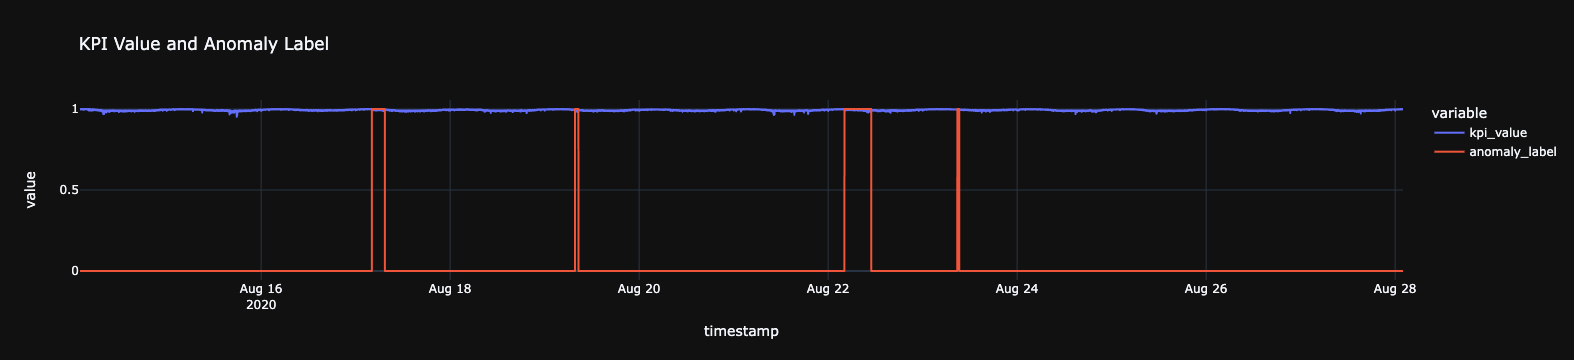

In [3]:
import plotly.express as px
fig = px.line(df, x="timestamp", y=['kpi_value', 'anomaly_label'], title='KPI Value and Anomaly Label', template='plotly_dark')
fig.show()

In [4]:
data=df['kpi_value']

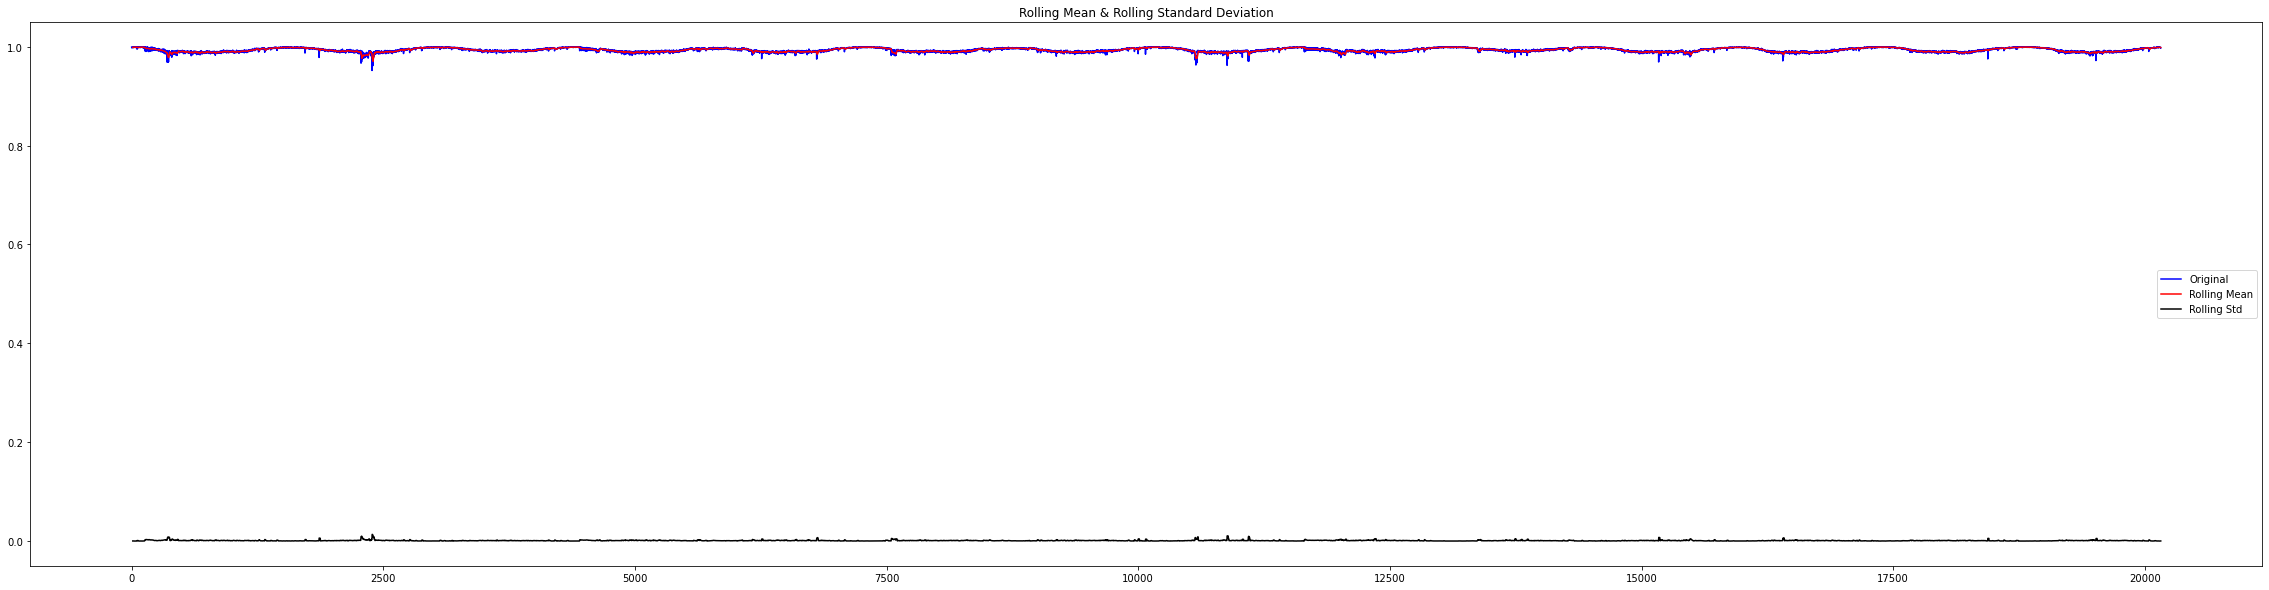

In [5]:
plt.figure(figsize=(40,10))
rolling_mean = data.rolling(window = 12).mean()
rolling_std = data.rolling(window = 12).std()
plt.plot(data, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [6]:
result = adfuller(data)
print('ADF Statistic: {}'.format(round(result[0],4)))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, round(float(value),4)))

ADF Statistic: -4.4285
p-value: 0.00026416616903197947
Critical Values:
	1%: -3.4307
	5%: -2.8617
	10%: -2.5668


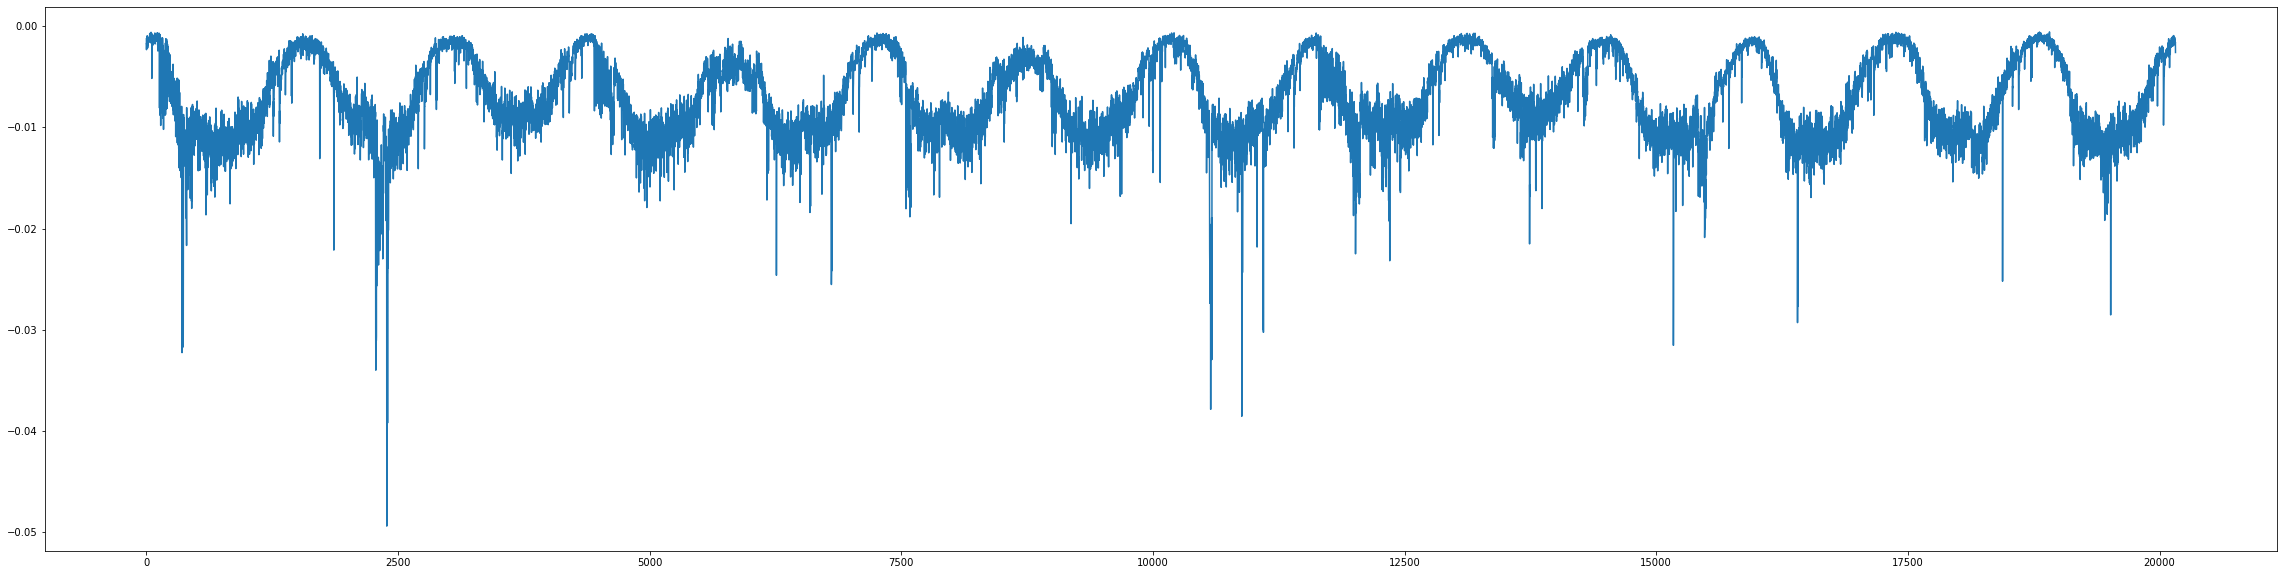

In [7]:
plt.figure(figsize=(40,10))
df_log = np.log(data)
plt.plot(df_log)

**Let’s create a function to run the two tests which determine whether a given time series is stationary.**

In [8]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    plt.figure(figsize=(40,10))
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(data)
    print('ADF Statistic: {}'.format(round(result[0],4)))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, round(float(value),4)))

**There are multiple transformations that we can apply to a time series to render it stationary. For instance, we subtract the rolling mean.**

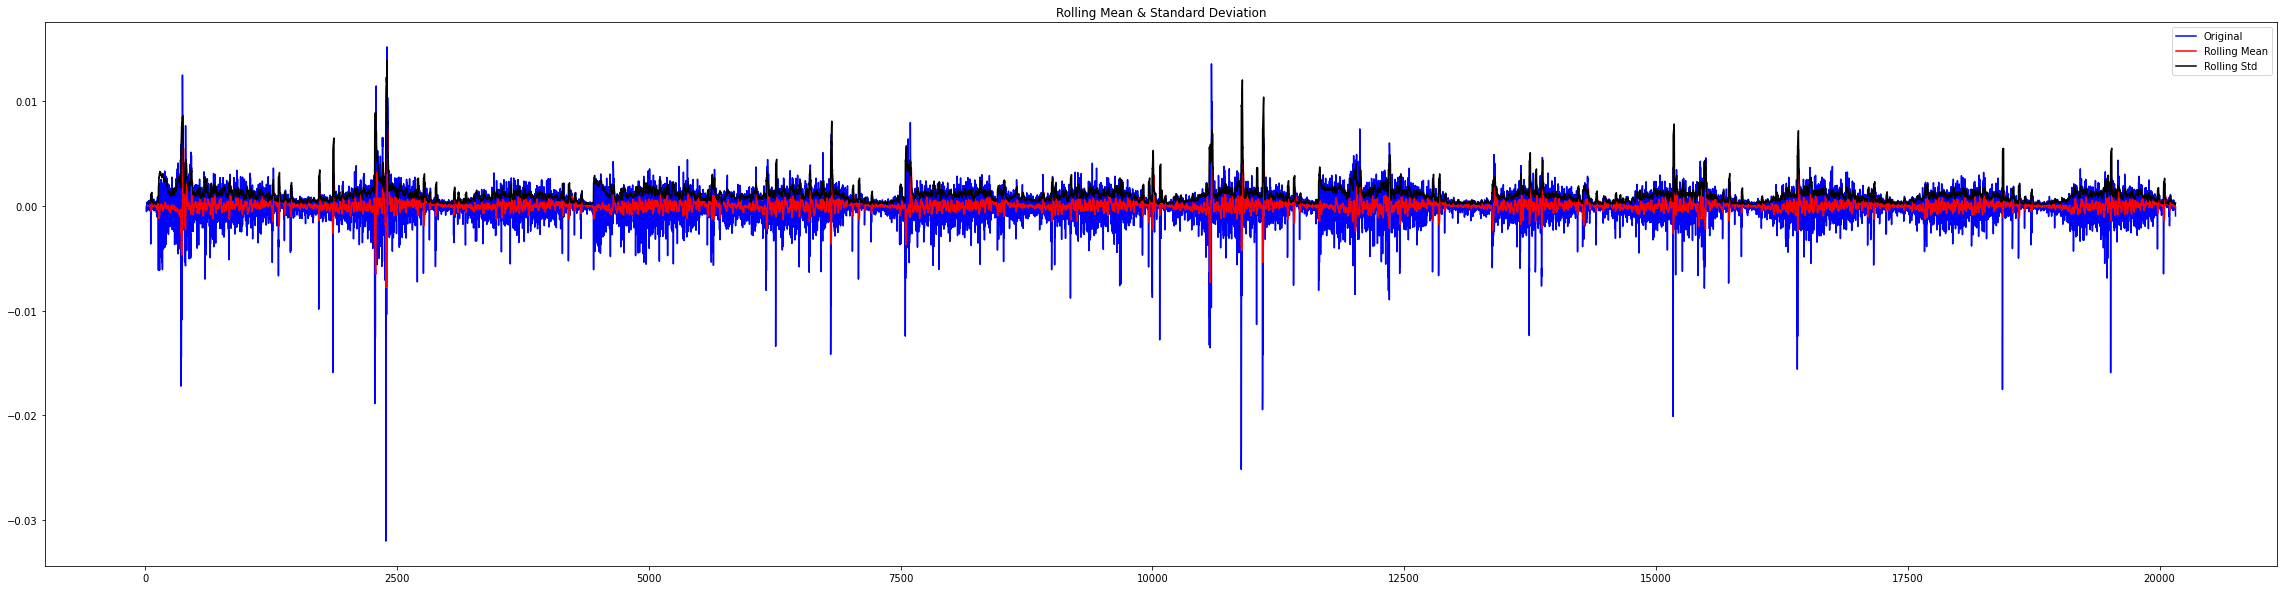

ADF Statistic: -4.4285
p-value: 0.00026416616903197947
Critical Values:
	1%: -3.4307
	5%: -2.8617
	10%: -2.5668


In [9]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

**Applying exponential decay is another way of transforming a time series such that it is stationary.**

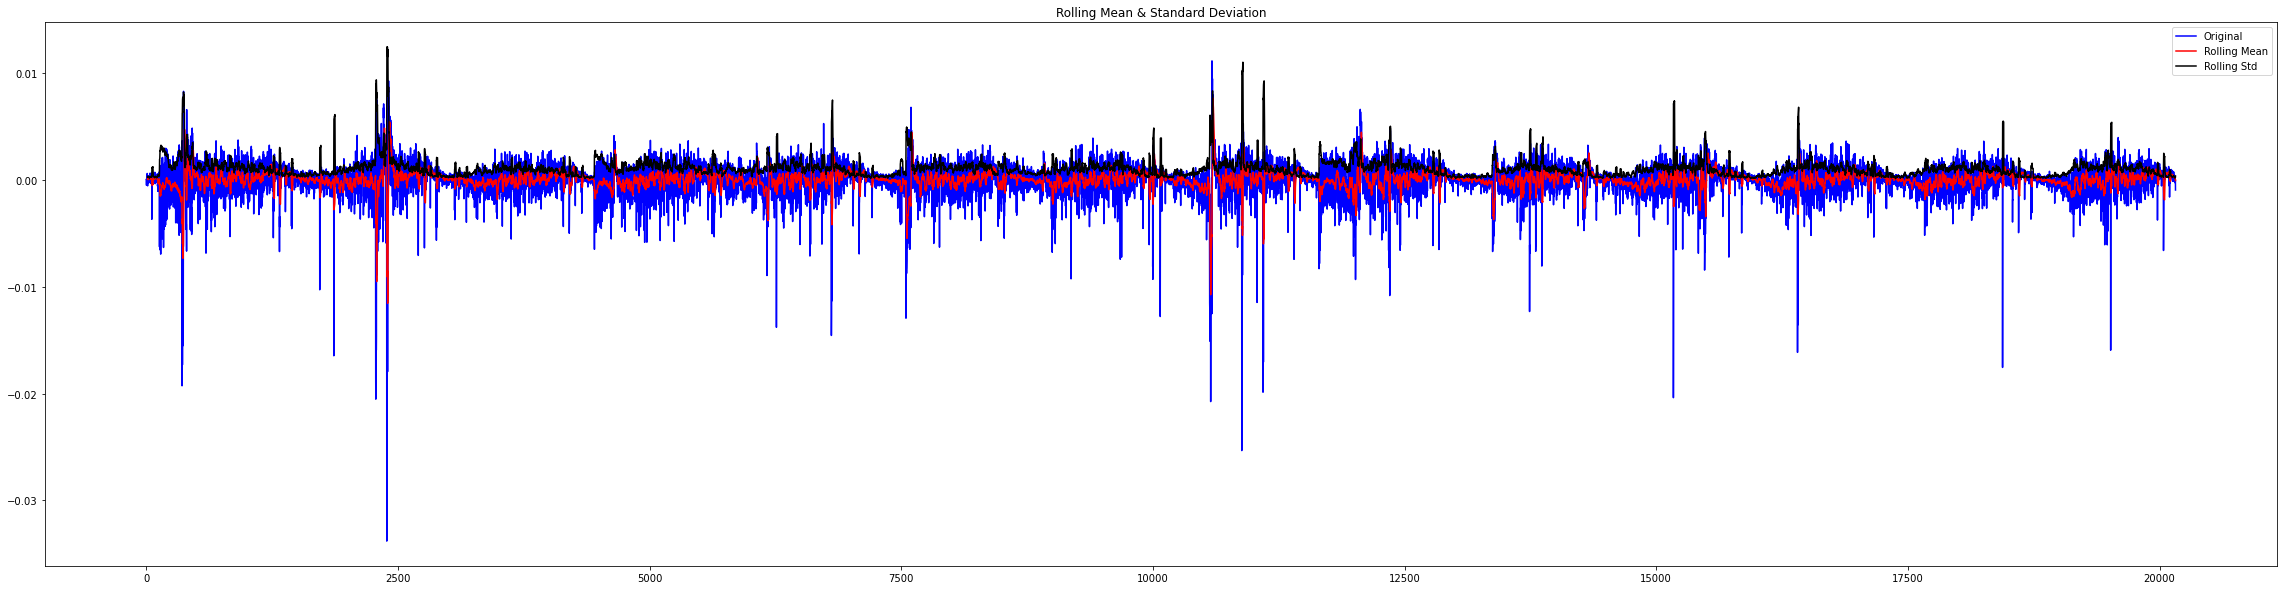

ADF Statistic: -4.4285
p-value: 0.00026416616903197947
Critical Values:
	1%: -3.4307
	5%: -2.8617
	10%: -2.5668


In [10]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

**Exponential decay performed worse than subtracting the rolling mean. However, it is still more stationary than the original.**

**Let’s try one more method to determine whether an even better solution exists. When applying time shifting, we subtract every the point by the one that preceded it.**

$$null, (x1−x0), (x2−x1), (x3−x2), (x4−x3), …, (xn−xn−1)$$

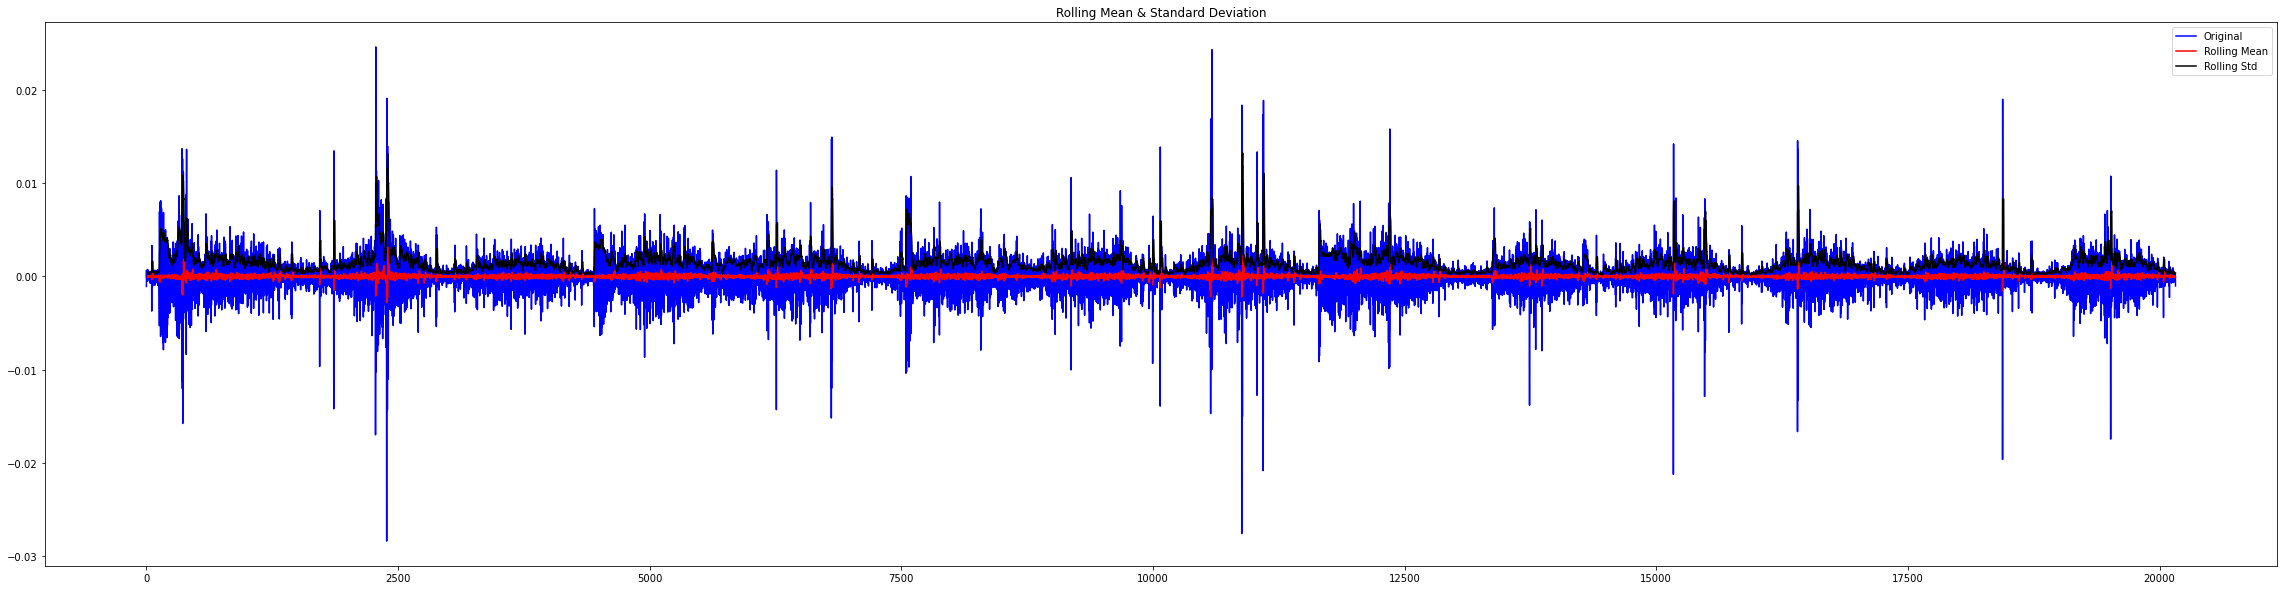

ADF Statistic: -4.4285
p-value: 0.00026416616903197947
Critical Values:
	1%: -3.4307
	5%: -2.8617
	10%: -2.5668


In [11]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

# AutoRegressive Model (AR)

In [12]:
df_log

0       -0.001245
1       -0.002320
2       -0.001660
3       -0.001791
4       -0.001599
           ...   
20154   -0.001853
20155   -0.001662
20156   -0.001638
20157   -0.001574
20158   -0.002596
Name: kpi_value, Length: 20159, dtype: float64

In [19]:
b = pd.Series(df_log)
b

0       -0.001245
1       -0.002320
2       -0.001660
3       -0.001791
4       -0.001599
           ...   
20154   -0.001853
20155   -0.001662
20156   -0.001638
20157   -0.001574
20158   -0.002596
Name: kpi_value, Length: 20159, dtype: float64

In [21]:
decomposition = seasonal_decompose(df_log, period=1000) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [14]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

NameError: name 'results' is not defined

In [15]:
results.plot_predict(1,264)

NameError: name 'results' is not defined